## Описание проекта

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

# 1. Подготовка

In [1]:
# Импорт необходимых библиотек и компонентов
import pandas as pd
import numpy as np
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

import lightgbm as lgb
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
# Импорт данных
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
# Сортировка по дате
data.sort_index(inplace=True)
# Почасовая разбивка заказов, т.к. нам нужно будет предсказывать количество заказов такси на следующий час 
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


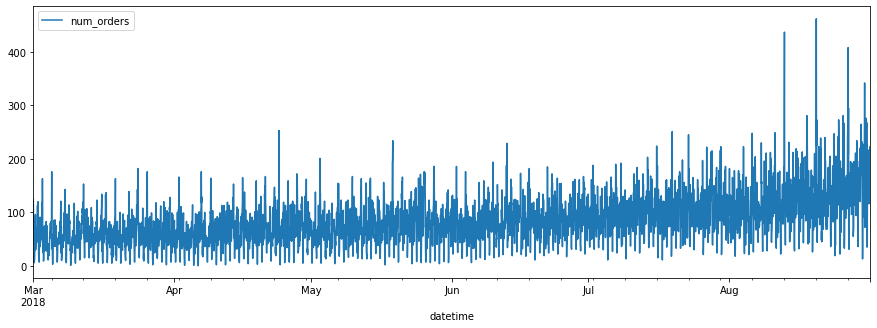

In [3]:
data.plot(figsize=(15,5))

# 2. Анализ

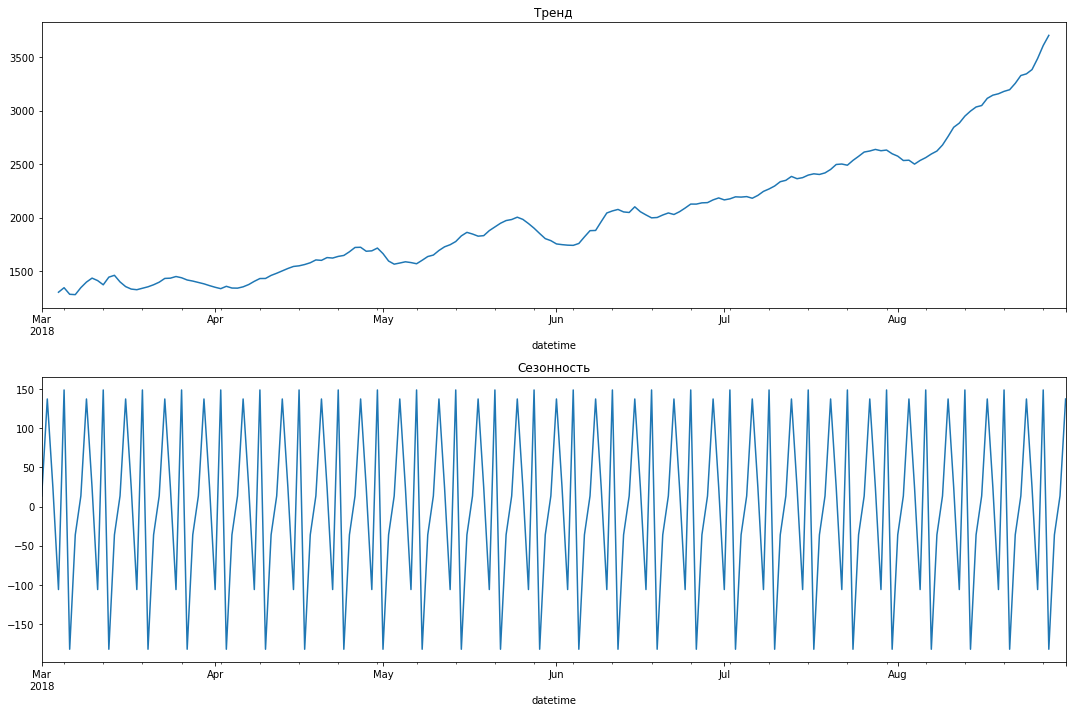

In [4]:
# Проанализируем данные по дням на предмет тренда и сезонности
data_d = data.resample('1D').sum()
decomposed = seasonal_decompose(data_d)
plt.figure(figsize=(15, 10))
plt.subplot(211)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(212)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.tight_layout()

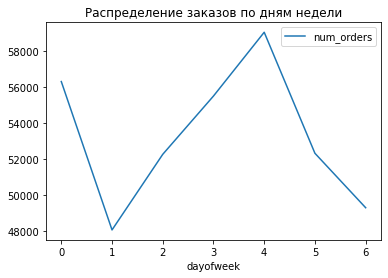

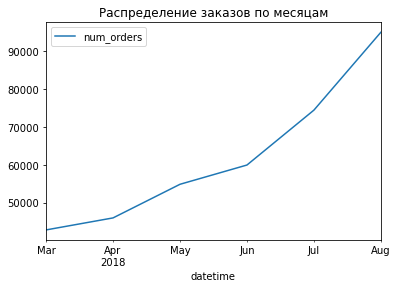

In [5]:
# Укрупним Распределение заказов по дням недели
data_dayofweek = data.copy()
data_dayofweek['dayofweek'] = data_dayofweek.index.dayofweek
data_dayofweek = data_dayofweek.groupby('dayofweek').sum()
data_dayofweek.plot(title = 'Распределение заказов по дням недели')
# Укрупним Распределение заказов по дням недели
data_m = data.resample('1M').sum()
data_m.plot(title = 'Распределение заказов по месяцам')

**Вывод** 
1. Существует выраженный тренд на увеличение количества заказов
2. Есть сезонность по дням недели.

# 3. Обучение

In [6]:
# Функция создания дополнительных признаков 
def make_features(data, max_lag, rolling_mean_size):
    data['week'] = data.index.week
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [7]:
# Функция подбор значений лага и окна 
def best_value (data, model):
    lag_best = 0
    roll_best = 0
    best_result = 10000
    for lag in range (10,20):
        for roll in range (25,35):
            make_features(data, lag, roll)

            # Отделение тестовой выборки
            train, test = train_test_split(data, shuffle=False, test_size=0.1)
            X_test = test.drop(['num_orders'], axis = 1)
            y_test = test['num_orders']
            train = train.dropna() 
            X_train = train.drop(['num_orders'], axis = 1)
            y_train = train['num_orders']

            model = model
            model.fit(X_train, y_train) 
            pred = model.predict(X_test)
            result = (mean_squared_error(y_test, pred))**0.5
            if result < best_result:
                lag_best = lag
                roll_best = roll
                best_result = result  
      
    print('Лучшее значение лага:', lag_best, 'Лучшее значение размера окна:', roll_best, "RMSE:", best_result)


In [8]:
# Лучшие значений лага и окна для разных моделей со значениями по умолчанию
best_value(data, LinearRegression(normalize=True))
best_value(data, CatBoostRegressor(silent=True))
best_value(data, lgb.LGBMRegressor())

Лучшее значение лага: 19 Лучшее значение размера окна: 25 RMSE: 47.06138046936784
Лучшее значение лага: 10 Лучшее значение размера окна: 30 RMSE: 47.29916674059931
Лучшее значение лага: 10 Лучшее значение размера окна: 34 RMSE: 47.484012896642845


## CatBoost

In [9]:
# Формирование признаков и отделение тестовой выборки
make_features(data, 10, 34)

train, test = train_test_split(data, shuffle=False, test_size=0.1)
X_test = test.drop(['num_orders'], axis = 1)
y_test = test['num_orders']

train = train.dropna() 
X_train = train.drop(['num_orders'], axis = 1)
y_train = train['num_orders']

In [10]:
# Отделение валидационной выборки
train_, val = train_test_split(train, shuffle=False, test_size=0.2)
train_ = train_.dropna()
val = val.dropna()

X_val = val.drop(['num_orders'], axis = 1)
y_val = val['num_orders']
X_train_ = train.drop(['num_orders'], axis = 1)
y_train_ = train['num_orders']

In [11]:
X_val.shape, X_train_.shape, X_test.shape

((788, 22), (3940, 22), (442, 22))

In [12]:
# Подбор гиперпараметров
best_result = 100000
learning_rate = [0.01, 0.1, 0.5]
max_depth = [1, 5, 7, 10]
for lr in learning_rate:
    for depth in max_depth:
        model = CatBoostRegressor(learning_rate = lr, max_depth = depth, eval_metric='RMSE', silent=True)
        model.fit(X_train_, y_train_)
        pred = model.predict(X_val)
        result = (mean_squared_error(y_val, pred))**0.5
        if result < best_result:
            best_depth = depth
            best_lr = lr
            best_result = result 
print('При max_depth =', best_depth, 'learning_rate =', best_lr, 'Наилучший показатель RMSE:', best_result)      

При max_depth = 10 learning_rate = 0.5 Наилучший показатель RMSE: 5.214836942503733e-06


In [13]:
# Оценка модели на тестовой выборке
model = CatBoostRegressor(max_depth = 10, learning_rate = 0.5, eval_metric='RMSE', silent=True)
model.fit(X_train, y_train) 
pred = model.predict(X_test)
rmse = (mean_squared_error(y_test, pred))**0.5
print("RMSE:", rmse)

RMSE: 54.024009815064765


## LightGBM

In [14]:
# Подбор гиперпараметров
best_result = 100000
learning_rate = [0.03, 0.5, 0.7]
max_depth = [1, 5, 7, 10]
for lr in learning_rate:
    for depth in max_depth:
        model = lgb.LGBMRegressor(learning_rate = lr, max_depth = depth, metric='rmse', silent=True)
        model.fit(X_train_, y_train_)
        pred = model.predict(X_val)
        result = (mean_squared_error(y_val, pred))**0.5
        if result < best_result:
            best_depth = depth
            best_lr = lr
            best_result = result 
print('При max_depth =', best_depth, 'learning_rate =', best_lr, 'Наилучший показатель RMSE:', best_result) 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

In [15]:
# Оценка модели на тестовой выборке
model = lgb.LGBMRegressor(metric='rmse', max_depth = 10, learning_rate = 0.07)
model.fit(X_train, y_train) 
pred = model.predict(X_test)
rmse = (mean_squared_error(y_test, pred))**0.5
print("RMSE:", rmse)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
RMSE: 48.142101393529046


# 4. Тестирование

Лучше моделью являтся LightGBM с характеристиками по умолчанию.
При этом лучшими параметрами для предварительной обработки временного ряда являются
*   Максимальный размер отставания - 10
*   Скользящее среднее - 29

Построим графики факт/предсказанное на одном рисунке. Чтобы увидеть где основные не "попадалки" модели.

In [16]:
y_test

datetime
2018-08-13 14:00:00    102
2018-08-13 15:00:00    175
2018-08-13 16:00:00    144
2018-08-13 17:00:00    152
2018-08-13 18:00:00    104
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 442, dtype: int64

In [17]:
aim = y_test.copy()
graf = y_test.reset_index()
graf['pred'] = pred
graf.loc[:170]

,datetime,num_orders,pred
0,2018-08-13 14:00:00,102,91.827646
1,2018-08-13 15:00:00,175,97.850408
2,2018-08-13 16:00:00,144,125.973676
3,2018-08-13 17:00:00,152,140.588808
4,2018-08-13 18:00:00,104,110.148052
...,...,...,...
166,2018-08-20 12:00:00,91,127.695461
167,2018-08-20 13:00:00,122,107.877579
168,2018-08-20 14:00:00,112,90.089949
169,2018-08-20 15:00:00,223,103.980080


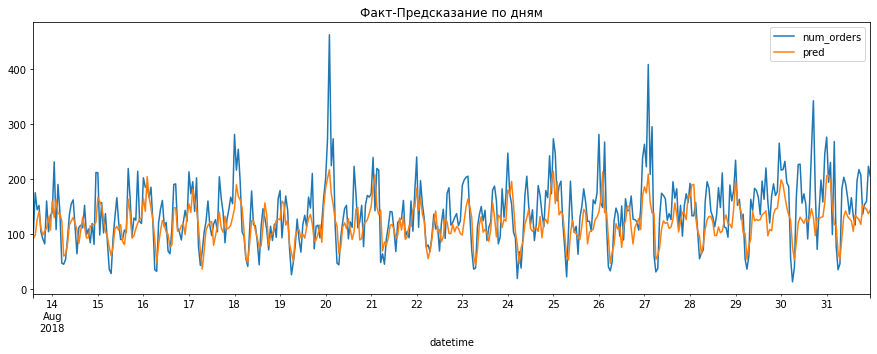

In [18]:
graf.set_index('datetime', inplace = True)
graf.plot(y=["num_orders", "pred"], figsize=(15,5), title = 'Факт-Предсказание по дням')
plt.show()

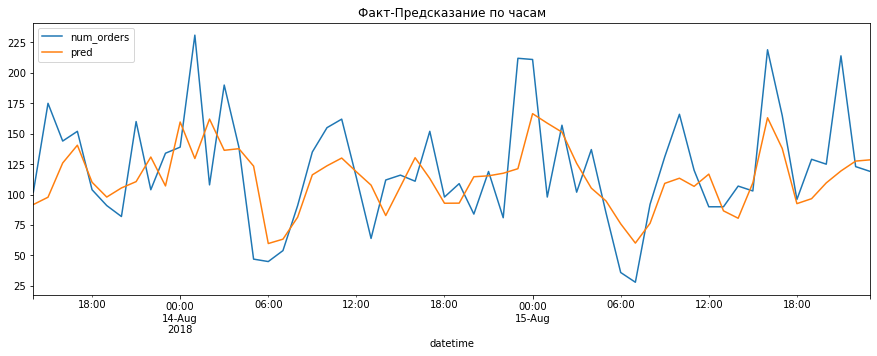

In [19]:
graf_1 = graf.loc[:'2018-08-15 23:00:00']
graf_1.plot(y=["num_orders", "pred"], figsize=(15,5), title = 'Факт-Предсказание по часам')
plt.show()

Видно, что предсказание не дотягивает значение до максимума. Это видимо сказывается большое сглаживание при формировании скользящего.